# `2_numba.ipynb`

This notebook focuses on accelerating the stencil computations presented in the [lists and NumPy notebook](./1_lists_numpy.ipynb) using [Numba](https://numba.pydata.org/).

In [1]:
import math
import random
import numpy as np
from numba import jit, prange, stencil
from IPython.display import Markdown as md

In [2]:
from common import initialize_field, plot_field, save_result, compare_results, read_results

In [3]:
from stencil2d import laplacian, update_halo, apply_diffusion

In [4]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

From Numba docs:

> Numba is a just-in-time compiler for Python that works best on code that uses NumPy arrays and functions, and loops. (...) When a call is made to a Numba-decorated function it is compiled to machine code “just-in-time” for execution and all or part of your code can subsequently run at native machine code speed!

> With a few simple annotations, array-oriented and math-heavy Python code can be just-in-time optimized to performance similar
as C, C++ and Fortran, without having to switch languages or Python interpreters.

The goal of this notebook is to show how we can use Numba and check whether we observe a performance gain compared to the results in [the first Jupyter notebook](1_lists_numpy.ipynb). Since Numba is a huge module, we will focus on testing the following components, which we believe are the most relevant features for stencil computations:

1. `@numba.jit(nopython=True)` or, equivalently, `@numba.njit`
2. `numba.prange()` together with `parallel=True`
3. `@numba.stencil`

Again, from the Numba docs:

> The Numba `@jit` decorator fundamentally operates in two compilation modes, nopython mode and object mode. (...) The behaviour of the nopython compilation mode is to essentially compile the decorated function so that it will run entirely without the involvement of the Python interpreter. This is the recommended and best-practice way to use the Numba jit decorator as it leads to the best performance.

> Assuming Numba can operate in nopython mode, or at least compile some loops, it will target compilation to your
specific CPU. **Speed up varies depending on application but can be one to two orders of magnitude**.

One has to be carefull to measure the performance using Numba. We are warned about this as well in the docs:

> A really common mistake when measuring performance is to not account for the above behaviour and to time code
once with a simple timer that includes the time taken to compile your function in the execution time.

For this reason, we will always execute a function at least once before benchmarking with `%%timeit`.

## Pointwise stencil

### Nested lists and `for` loops

Numba docs suggest that we should work with NumPy arrays and loops, but let's see if it can do anything with lists.

In [5]:
@jit(nopython=True)
def list_numba_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

In [6]:
in_field = initialize_field(NX, NY, NZ)
out_field = np.zeros_like(in_field).tolist()
in_field = in_field.tolist()
# out_field = list_numba_pointwise(in_field, out_field)  # TypeError

Numba does not like lists, and while the explanation of the `TypeError` is not very clear, the solution is: **use NumPy arrays**!

On second thought, it is not surprising that Numba cannot deal with lists and prefers NumPy arrays, since as we have seen in [the previous notebook](./1_lists_numpy.ipynb) arrays already have a C-alike data buffer, but lists are just a vector of pointers to *any* Python object.

### NumPy arrays and `for` loops

In [7]:
@jit(nopython=True)
def numba_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

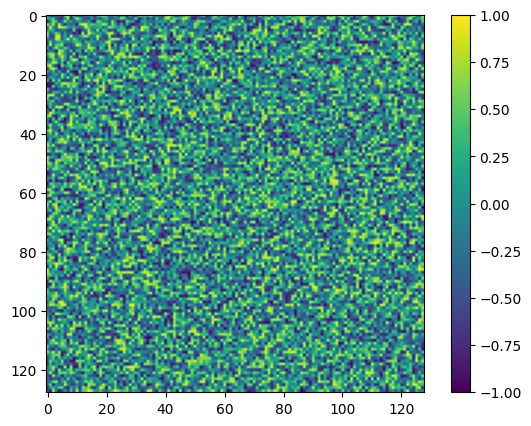

In [8]:
in_field = initialize_field(NX, NY, NZ)
out_field = np.zeros_like(in_field)
# This call is just so that Numba compiles the function before we benchmark
# Also, to check correctness!
out_field = numba_pointwise(in_field, out_field)
plot_field(out_field)

In [9]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_pointwise(in_field, out_field)

30.8 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 30.8 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [10]:
result_numba_pointwise = _
save_result(result_numba_pointwise, "numba_pointwise")

In [11]:
time_list_pointwise = read_results("list_pointwise")
time_array_pointwise = read_results("array_pointwise")
numba_vs_lists = compare_results(result_numba_pointwise.average, time_list_pointwise, "faster")
numba_vs_arrays = compare_results(result_numba_pointwise.average, time_array_pointwise, "faster")

md(f"""
Numba works! The exact speedup is platform specific, but when comparing the numbers running everything
in the CSCS JupyterLab we observe that this code is **{numba_vs_lists} times faster than pure python code (lists)**
and **{numba_vs_arrays} times faster than NumPy arrays with `for` loops**. It is astonishing that this is achieved
by simply adding a decorator on top of the function definition!
""")


Numba works! The exact speedup is platform specific, but when comparing the numbers running everything
in the CSCS JupyterLab we observe that this code is **~268 times faster than pure python code (lists)**
and **~493 times faster than NumPy arrays with `for` loops**. It is astonishing that this is achieved
by simply adding a decorator on top of the function definition!


In [12]:
time_numpy_pointwise = read_results("numpy_pointwise")

md(f"""
| Function                  | Time                                          |
|:--------------------------|----------------------------------------------:|
| `list_pointwise()`        |  {time_list_pointwise}s                       |
| `array_pointwise()`       |  {time_array_pointwise}s                      |
| `numpy_pointwise()`       |  {time_numpy_pointwise * 1e6:.1f}μs           |
| `numba_pointwise()`       |  {result_numba_pointwise.average * 1e3:.1f}ms |
""")


| Function                  | Time                                          |
|:--------------------------|----------------------------------------------:|
| `list_pointwise()`        |  8.25s                       |
| `array_pointwise()`       |  15.2s                      |
| `numpy_pointwise()`       |  36.4μs           |
| `numba_pointwise()`       |  30.8ms |


NumPy is still 3 orders of magnitude faster than the Numba code! But this will only happen for the simple copy stencil and the result, besides being hardware specific, can only be observed for certain sizes of arrays. The reason why NumPy is so fast in this case was explained in an appendix of [previous Notebook](./1_lists_numpy.ipynb). Let's rerun the test with arrays large enough so that they don't fit in L3 cache.

In [13]:
NZ = NY = NX = 190

In [14]:
def numpy_pointwise(in_field, out_field):
    for n in range(N_ITER):
        out_field[:, :, :] = in_field[:, :, :]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

In [15]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

274 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_pointwise(in_field, out_field)

36.6 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


So for our particular 3D fiels, Numba is slower than NumPy with the copy stencil, but for larger arrays this is no longer the case.

In [17]:
NY = NX = 128
NZ = 80

In [18]:
@jit(nopython=True)
def numba_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = math.sin(in_field[k, j, i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

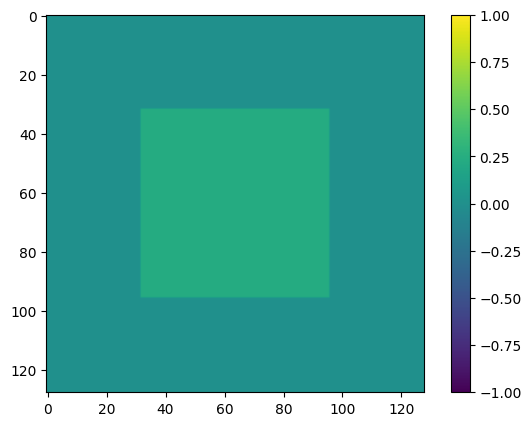

In [19]:
in_field = initialize_field(NX, NY, NZ, mode="square"); out_field = np.zeros_like(in_field)
out_field = numba_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [20]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_sin_pointwise(in_field, out_field)

832 ms ± 493 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 832 ms ± 493 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [21]:
result_numba_sin_pointwise = _
save_result(result_numba_sin_pointwise, "numba_sin_pointwise")

In [22]:
time_list_sin_pointwise = read_results("list_sin_pointwise")
time_array_sin_pointwise = read_results("array_sin_pointwise")
numba_vs_lists = compare_results(result_numba_sin_pointwise.average, time_list_sin_pointwise, "faster")
numba_vs_arrays = compare_results(result_numba_sin_pointwise.average, time_array_sin_pointwise, "faster")

md(f"""
Applying `sin()` instead of a simple copy we also observed a very noticable increase in performance.
Numba code is **{numba_vs_lists} times faster than pure python code (lists)** and **{numba_vs_arrays} times
faster than NumPy arrays with `for` loops**.
""")


Applying `sin()` instead of a simple copy we also observed a very noticable increase in performance.
Numba code is **~18 times faster than pure python code (lists)** and **~29 times
faster than NumPy arrays with `for` loops**.


In [23]:
time_list_sin_pointwise = read_results("list_sin_pointwise")
time_numpy_sin_pointwise = read_results("numpy_sin_pointwise")

md(f"""
| Function                  | Time                                              |
|:--------------------------|--------------------------------------------------:|
| `list_sin_pointwise()`    |  {time_list_sin_pointwise}s                       |
| `array_sin_pointwise()`   |  {time_array_sin_pointwise}s                      |
| `numpy_sin_pointwise()`   |  {time_numpy_sin_pointwise * 1e3:.0f}ms           |
| `numba_sin_pointwise()`   |  {result_numba_sin_pointwise.average * 1e3:.0f}ms |
""")


| Function                  | Time                                              |
|:--------------------------|--------------------------------------------------:|
| `list_sin_pointwise()`    |  14.7s                       |
| `array_sin_pointwise()`   |  23.9s                      |
| `numpy_sin_pointwise()`   |  874ms           |
| `numba_sin_pointwise()`   |  832ms |


Numba and vectorized NumPy are quite similar in terms of performance. But we can further improve Numba performance by using all the cores of the CPU passing to the decorator `@jit` the argument `parallel=True`

> If code contains operations that are parallelisable (and supported) Numba can compile a version that will run in parallel
on multiple native threads (no GIL!).

In addition, we can do something similar to what we did with OpenMP and Fortran during the course.

> Numba parallel execution also has support for explicit parallel loop declaration similar to that in OpenMP. To indicate
that a loop should be executed in parallel the `numba.prange` function should be used, this function behaves like Python
range and if `parallel=True` is not set it acts simply as an alias of range.

In [24]:
@jit(nopython=True, parallel=True)
def numba_parallel_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        # We use prange instead of range for the Z axis
        # Each core will compute a XY plane in parallel
        for k in prange(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = math.sin(in_field[k, j, i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

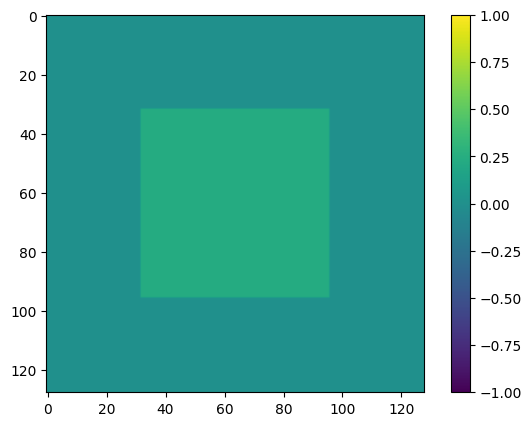

In [25]:
in_field = initialize_field(NX, NY, NZ, mode="square"); out_field = np.zeros_like(in_field)
out_field = numba_parallel_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [26]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_parallel_sin_pointwise(in_field, out_field)

61.1 ms ± 430 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 61.1 ms ± 430 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [27]:
result_numba_parallel_sin_pointwise = _
save_result(result_numba_parallel_sin_pointwise, "numba_parallel_sin_pointwise")

In [28]:
numba_parallel_vs_numpy = compare_results(result_numba_parallel_sin_pointwise.average, time_numpy_sin_pointwise, "faster")
numba_vs_lists = compare_results(result_numba_parallel_sin_pointwise.average, time_list_sin_pointwise, "faster")

md(f"""
Using `prange` and `parallel=True` we can make Numba code **{numba_parallel_vs_numpy} times faster than
the vectorized NumPy code**, and **{numba_vs_lists} times faster than pure Python code**.
This speedup, obviously, depends on the number of cores we have available.
""")


Using `prange` and `parallel=True` we can make Numba code **~14 times faster than
the vectorized NumPy code**, and **~241 times faster than pure Python code**.
This speedup, obviously, depends on the number of cores we have available.


In [29]:
md(f"""
| Function                         | Time                                                       |
|:---------------------------------|-----------------------------------------------------------:|
| `numpy_sin_pointwise()`          |  {time_numpy_sin_pointwise * 1e3:.0f}ms                    |
| `numba_sin_pointwise()`          |  {result_numba_sin_pointwise.average * 1e3:.0f}ms          |
| `numba_parallel_sin_pointwise()` |  {result_numba_parallel_sin_pointwise.average * 1e3:.0f}ms |
""")


| Function                         | Time                                                       |
|:---------------------------------|-----------------------------------------------------------:|
| `numpy_sin_pointwise()`          |  874ms                    |
| `numba_sin_pointwise()`          |  832ms          |
| `numba_parallel_sin_pointwise()` |  61ms |


For completeness, let's rerun the simple copy pointwise stencil also taking advantage of `parallel=True`.

In [30]:
@jit(nopython=True, parallel=True)
def numba_parallel_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in prange(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

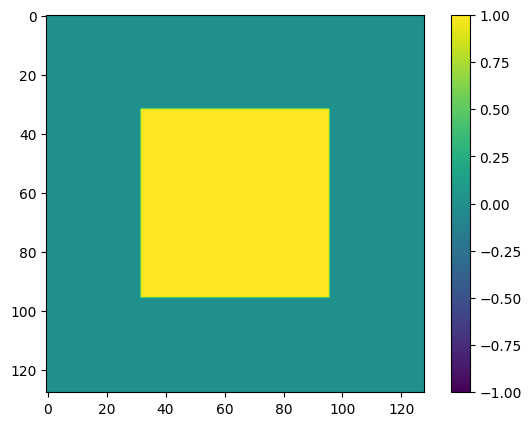

In [31]:
# compile
in_field = initialize_field(NX, NY, NZ, mode="square"); out_field = np.zeros_like(in_field)
out_field = numba_parallel_pointwise(in_field, out_field)
plot_field(out_field)

In [32]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_parallel_pointwise(in_field, out_field)

3.2 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.2 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [33]:
result_numba_parallel_pointwise = _
save_result(result_numba_parallel_pointwise, "numba_parallel_pointwise")

In [34]:
md(f"""
| Function                     |  Time                                                  |
|:-----------------------------|-------------------------------------------------------:|
| `numpy_pointwise()`          |  {time_numpy_pointwise * 1e6:.1f}μs                    |
| `numba_pointwise()`          |  {result_numba_pointwise.average * 1e3:.1f}ms          |
| `numba_parallel_pointwise()` |  {result_numba_parallel_pointwise.average * 1e3:.1f}ms |
""")


| Function                     |  Time                                                  |
|:-----------------------------|-------------------------------------------------------:|
| `numpy_pointwise()`          |  36.4μs                    |
| `numba_pointwise()`          |  30.8ms          |
| `numba_parallel_pointwise()` |  3.2ms |


### NumPy arrays with vectorized code

Remember that in the Numba docs it was explained that we should keep the loops. In this section we will show that Numba is not able to optimize code with Numpy vectorized expressions as good as functions with `for` loops.

In [35]:
@jit(nopython=True, parallel=True)
def numba_vectorized_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        out_field = np.sin(in_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

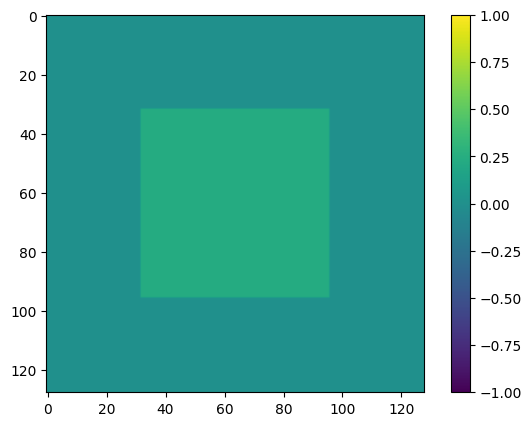

In [36]:
in_field = initialize_field(NX, NY, NZ, mode="square"); out_field = np.zeros_like(in_field)
out_field = numba_vectorized_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [37]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_vectorized_sin_pointwise(in_field, out_field)

75.5 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 75.5 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [38]:
result_numba_vectorized_sin_pointwise = _
save_result(result_numba_vectorized_sin_pointwise, "numba_vectorized_sin_pointwise")

In [39]:
md(f"""
| Function                           |  Time                                                        |
|:-----------------------------------|-------------------------------------------------------------:|
| `numpy_sin_pointwise()`            |  {time_numpy_sin_pointwise * 1e3:.0f}ms                      |
| `numba_parallel_sin_pointwise()`   |  {result_numba_parallel_sin_pointwise.average * 1e3:.1f}ms   |
| `numba_vectorized_sin_pointwise()` |  {result_numba_vectorized_sin_pointwise.average * 1e3:.1f}ms |
""")


| Function                           |  Time                                                        |
|:-----------------------------------|-------------------------------------------------------------:|
| `numpy_sin_pointwise()`            |  874ms                      |
| `numba_parallel_sin_pointwise()`   |  61.1ms   |
| `numba_vectorized_sin_pointwise()` |  75.5ms |


In conclusion, the best way to use Numba (at lest for the pointwise stencil) seems to keep all the `for` loops (i.e., avoid array slicing), avoid using the vectorized NumPy functions, and take advantage of all the cores by passing `parallel=True` to the `@njit` decorator. The speedup observed in this section agrees with the claims from their documentation.

## 1D stencils

With the lessons learned from the pointwise stencil, now we will focus on using NumPy arrays keeping the `for` loops and checking whether we still need to keep in mind the right order of the loops to optimize cache utilization or if Numba can do this for us, and also if working with C-style or Fortran-style data buffers is relevant for Numba.

From now on, we will always keep `parallel=True` and use `prange` in the Z dimension.

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

Let's check if the order of the loops affect the compiled code performance. Instead of testing all the 6 permutations, we will just test the two while keeping the Z in the outermost loop. We will also keep the periodic update operation always in the innermost loop, despite we could move it one identation to the left when iterating in the order ZYX.

In [40]:
@jit(nopython=True, parallel=True)
def numba_1D_same_col_ZYX(in_field, out_field):
    for n in range(N_ITER):
        for k in prange(NZ):
            for j in range(NY):
                for i in range(NX - 1):
                    out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
                    # Periodic boundary condition
                    out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

@jit(nopython=True, parallel=True)
def numba_1D_same_col_ZXY(in_field, out_field):
    for n in range(N_ITER):
        for k in prange(NZ):
            for i in range(NX - 1):
                for j in range(NY):
                    out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
                    # Periodic boundary condition
                    out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

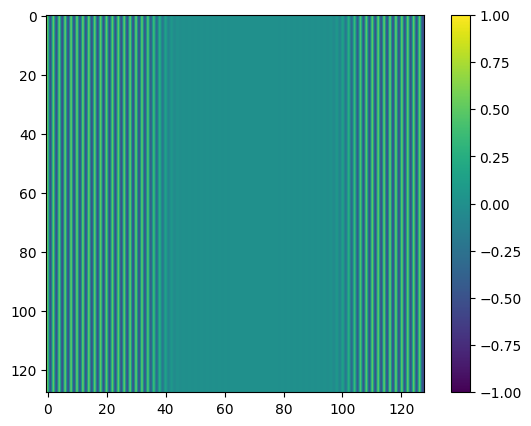

In [41]:
in_field = initialize_field(NX, NY, NZ, mode="vertical-bars"); out_field = np.zeros_like(in_field)
out_field = numba_1D_same_col_ZYX(in_field, out_field)
plot_field(out_field)

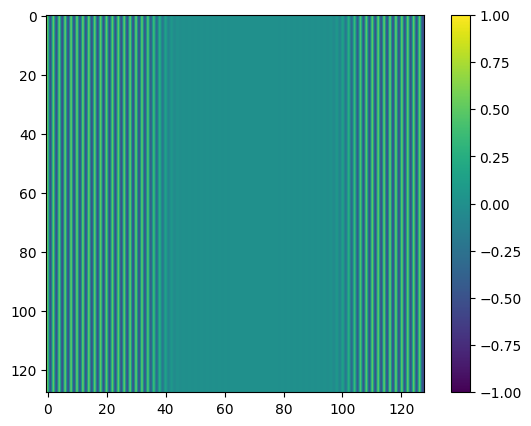

In [42]:
in_field = initialize_field(NX, NY, NZ, mode="vertical-bars"); out_field = np.zeros_like(in_field)
out_field = numba_1D_same_col_ZXY(in_field, out_field)
plot_field(out_field)

In [43]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_1D_same_col_ZYX(in_field, out_field)

5.27 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_1D_same_col_ZXY(in_field, out_field)

30.5 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It seems like the order of the loops still matter, so we should keep the right order to maximize performance. But perhaps Numba is optimizing the code and already calling less times the update in the boundary points. Let's check if that's the case.

In [45]:
@jit(nopython=True, parallel=True)
def numba_1D_same_col_ZYX_alt(in_field, out_field):
    for n in range(N_ITER):
        for k in prange(NZ):
            for j in range(NY):
                for i in range(NX - 1):
                    out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
                # Notice we have move this line to the loop over Y dimension
                out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

In [46]:
# compile function
in_field = initialize_field(NX, NY, NZ, mode="vertical-bars"); out_field = np.zeros_like(in_field)
out_field = numba_1D_same_col_ZYX_alt(in_field, out_field)

In [47]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_1D_same_col_ZYX_alt(in_field, out_field)

3.53 ms ± 98 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.53 ms ± 98 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [48]:
result_numba_1D_same_col = _
save_result(result_numba_1D_same_col, "numba_1D_same_col")

No, that was not the case. Numba is compiling the code literally from our Python definition without further "hidden" optimizations.

Choosing the right order for the loops is still relevant when accelerating code with Numba. This is not surprising since not only we are probably improving the cache hits when using the right order, but also we are calling less times the code that implements the periodic boundary conditions.

Let's check one more time that the code with `for` loops is optimized better than NumPy vectorized code. 

In [49]:
@jit(nopython=True, parallel=True)
def numba_vectorized_1D_same_col(in_field, out_field):
    for n in range(N_ITER):
        out_field[:, :, :-1] = 0.5 * (in_field[:, :, 1:] - in_field[:, :, :-1])
        # Periodic boundary condition
        out_field[:, :, -1] = 0.5 * (in_field[:, :, 0] - in_field[:, :, -1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

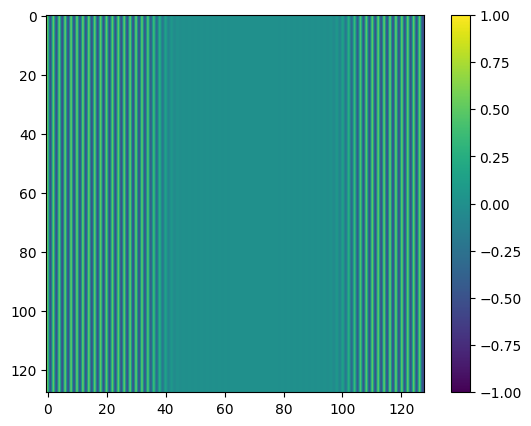

In [50]:
in_field = initialize_field(NX, NY, NZ, mode="vertical-bars"); out_field = np.zeros_like(in_field)
out_field = numba_vectorized_1D_same_col(in_field, out_field)
plot_field(out_field)

In [51]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, array_order="C"); out_field = np.zeros_like(in_field)
out_field = numba_vectorized_1D_same_col(in_field, out_field)

9.67 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 9.67 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [52]:
result_numba_vectorized_1D_same_col = _
save_result(result_numba_vectorized_1D_same_col, "numba_vectorized_1D_same_col")

In [53]:
%%timeit in_field = initialize_field(NX, NY, NZ, array_order="F"); out_field = np.zeros_like(in_field)
out_field = numba_vectorized_1D_same_col(in_field, out_field)

45.1 ms ± 60.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Indeed, we obtain worse results, but we also observe an interesting fact. Remember that because of the different size of the strides, Fortran-style arrays were faster that C-style arrays when working with this stencil. Now with Numba we observe the opposite, suggesting that Numba is optimized to work with row-major data buffers.

Let's quickly run a similar test like we did with NumPy. Let's increase `NZ` and rerun the benchmarks.

In [54]:
NZ = 128

In [55]:
%%timeit in_field = initialize_field(NX, NY, NZ, array_order="C"); out_field = np.zeros_like(in_field)
out_field = numba_vectorized_1D_same_col(in_field, out_field)

14 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
%%timeit in_field = initialize_field(NX, NY, NZ, array_order="F"); out_field = np.zeros_like(in_field)
out_field = numba_vectorized_1D_same_col(in_field, out_field)

88 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
NZ = 80

In [58]:
time_numpy_1D_same_col = read_results("numpy_1D_same_col")

md(f"""
| Function                         |  Time                                                      |
|:---------------------------------|-----------------------------------------------------------:|
| `numpy_1D_same_col()`            |  {time_numpy_1D_same_col * 1e3:.0f}ms                      |
| `numba_1D_same_col()`            |  {result_numba_1D_same_col.average * 1e3:.1f}ms            |
| `numba_vectorized_1D_same_col()` |  {result_numba_vectorized_1D_same_col.average * 1e3:.1f}ms |
""")


| Function                         |  Time                                                      |
|:---------------------------------|-----------------------------------------------------------:|
| `numpy_1D_same_col()`            |  114ms                      |
| `numba_1D_same_col()`            |  3.5ms            |
| `numba_vectorized_1D_same_col()` |  9.7ms |


In [59]:
numba_vs_numpy = compare_results(result_numba_1D_same_col.average, time_numpy_1D_same_col, "faster")

md(f"""
The summary of this table and main conclusion is that Numba can speedup the 1D stencil code but updating
the field in the right order is still relevant. In the ideal scenario, **Numba code is {numba_vs_numpy}
faster that the NumPy code**.

Using Numba against vectorized NumPy code increases performance but only because we use more threads. The result
is still slower than the code with loops. It also seems that working with C-style arrays is preferred.
This is not totally surprising since in previous versions of Numba, Fortran-style arrays were not even supported.
For example, the parallel accelerator `@njit(parallel=True)` supports Fortran ordered arrays only since version
0.53.0.
""")


The summary of this table and main conclusion is that Numba can speedup the 1D stencil code but updating
the field in the right order is still relevant. In the ideal scenario, **Numba code is ~32
faster that the NumPy code**.

Using Numba against vectorized NumPy code increases performance but only because we use more threads. The result
is still slower than the code with loops. It also seems that working with C-style arrays is preferred.
This is not totally surprising since in previous versions of Numba, Fortran-style arrays were not even supported.
For example, the parallel accelerator `@njit(parallel=True)` supports Fortran ordered arrays only since version
0.53.0.


### Same row: $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

In [60]:
@jit(nopython=True, parallel=True)
def numba_1D_same_row(in_field, out_field):
    for n in range(N_ITER):
        for k in prange(NZ):
            for i in range(NX):
                for j in range(NY-1):
                    out_field[k, j, i] = 0.5 * (in_field[k, j+1, i] - in_field[k, j, i])
                out_field[k, NY-1, i] = 0.5 * (in_field[k, 0, i] - in_field[k, NY-1, i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field  
    return out_field

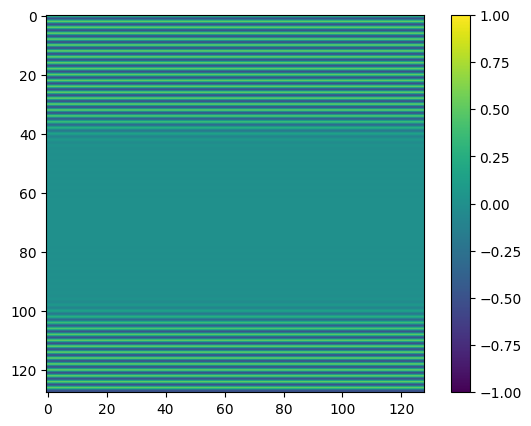

In [61]:
in_field = initialize_field(NX, NY, NZ, mode="horizontal-bars"); out_field = np.zeros_like(in_field)
out_field = numba_1D_same_row(in_field, out_field)
plot_field(out_field)

In [62]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_1D_same_row(in_field, out_field)

17.4 ms ± 923 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This is much slower than our previous result. It seems that the cache hit ratio is much smaller in this case because we are updating the second index instead of the last one, which is the optimal for a row-major data buffer. Let's test this hypothesis by initializing our fields with `dim_order="ZXY`.

In [63]:
@jit(nopython=True, parallel=True)
def numba_1D_same_row_alt(in_field, out_field):
    for n in range(N_ITER):
        for k in prange(NZ):
            for i in range(NX):
                for j in range(NY-1):
                    out_field[k, i, j] = 0.5 * (in_field[k, i, j+1] - in_field[k, i, j])
                out_field[k, i, NY-1] = 0.5 * (in_field[k, i, 0] - in_field[k, i, NY-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field  
    return out_field

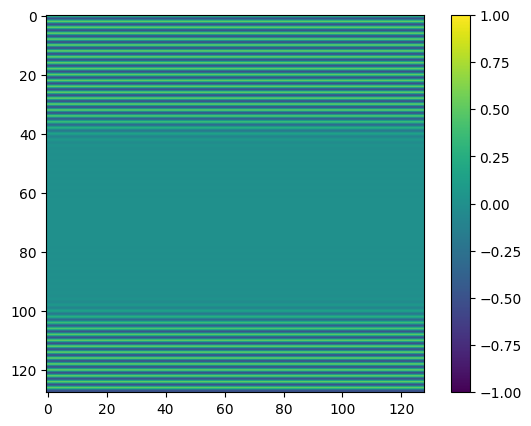

In [64]:
in_field = initialize_field(NX, NY, NZ, dim_order="ZXY", mode="horizontal-bars"); out_field = np.zeros_like(in_field)
out_field = numba_1D_same_row_alt(in_field, out_field)
plot_field(out_field, dim_order="ZXY")

In [65]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, dim_order="ZXY"); out_field = np.zeros_like(in_field)
out_field = numba_1D_same_row_alt(in_field, out_field)

3.58 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.58 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [66]:
result_numba_1D_same_row = _
save_result(result_numba_1D_same_row, "numba_1D_same_row")

Initializing the array with the optimal order for the dimensions helped us recover the same results as for the other 1D stencil. This shows that all the lessons learned with lists and NumPy arrays are still useful when trying to optimize code with Numba.

The main takeaway is that we should use **C-style NumPy arrays** and maximize cache utilization when possible by choosing the right order for the loops and the order for the dimensions.

## 2D field

The 4th-order diffusion we used in the course is the right stencil to test the `@stencil` decorator. It is very simple to write stencils with Numba but, unfortunately, at the moment there is not a simple way to implement the periodic boundary conditions. In the future it may be possible using the `func_or_mode` parameter. With current latest version of Numba only `func_or_mode="constan"` is supported, which means that the elements of the field outside a valid range are considered constant with the value `cval`, which by default is 0.

In [67]:
@stencil
def laplacian_numba_stencil(field):
    return -4.0 * field[0, 0, 0] + field[0, -1, 0] \
           + field[0, 1, 0] + field[0, 0, -1] + field[0, 0, 1]

In [68]:
field = initialize_field(NX, NY, NZ)
lap_field = np.zeros_like(field)

In [69]:
%timeit laplacian(field, lap_field, num_halo=2, extend=0)

7.56 ms ± 82.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
%timeit laplacian_numba_stencil(field)

601 ms ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The Numba stencil code is much slower because the `@stencil` decorator does not compile anything. It just transforms the compact code using relative coordinates into a Python function with the absolute indices. The speedup can only be obtain later combining this function with `@jit`.

In order to have periodic boundaries we have to use the same trick as done in the `stencil2d.py` module, i.e., write a new `update_halo()` function. This time we write this function with `for` loops to fully benefit from Numba. We can use the `prange` on the Z axis.

In [71]:
@jit(nopython=True, parallel=True)
def update_halo_numba(field, num_halo):
    for k in prange(NZ):
        for j in range(num_halo):
            for i in range(NX - 2 * num_halo):
                # updating top edge (without corners)
                field[k, j, num_halo + i] = field[k, NY - 2 * num_halo + j, num_halo + i]
                # updating bottom edge (without corners)
                field[k, NY - num_halo + j, num_halo + i] = field[k, num_halo + j, num_halo + i]
        for j in range(NY):
            for i in range(num_halo):
                # updating left edge (with corners)
                field[k, j, i] = field[k, j, NX - 2 * num_halo + i]
                # updating right edge (with corners)
                field[k, j, NX - num_halo + i] = field[k, j, num_halo + i]

Let's tests the `update_halo_numba()` against the implementation from `stencil2d.py`. First we check that the implementation is correct.

True

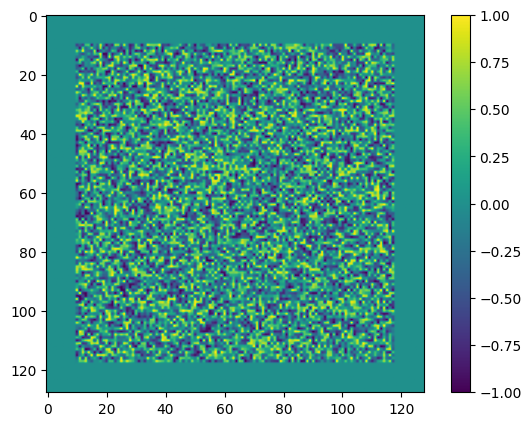

In [72]:
field = initialize_field(NX, NY, NZ, num_halo=10)
copy_field = field.copy()
plot_field(field)
np.array_equal(field, copy_field)

False

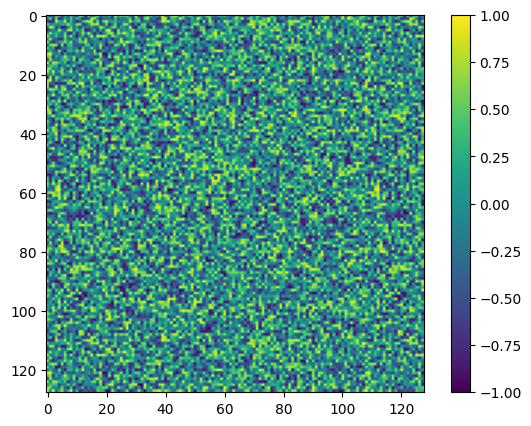

In [73]:
update_halo(field, num_halo=10)
plot_field(field)
np.array_equal(field, copy_field)

True

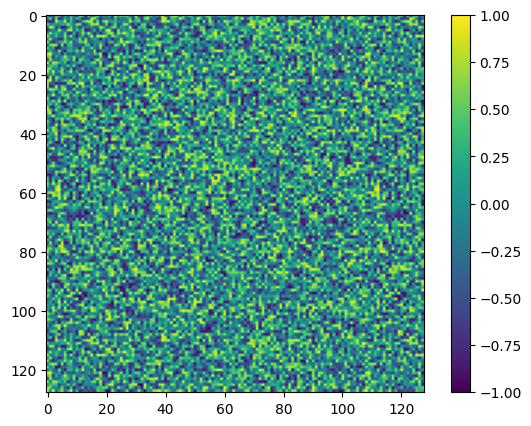

In [74]:
update_halo_numba(copy_field, num_halo=10)
plot_field(copy_field)
np.array_equal(field, copy_field)

And now we check the perfomance.

In [75]:
%%timeit field = initialize_field(NX, NY, NZ)
update_halo(field, num_halo=2)

634 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [76]:
%%timeit field = initialize_field(NX, NY, NZ)
update_halo_numba(field, num_halo=2)

21.8 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Numba code for the halo update is clearly faster.

Finally, we implement the diffusion operator using an explicit definition of the discretization rather than calling two times the laplacian operator. In the future, if `@stencil` is extended with additional `func_or_mode`, perhaps is possible to implement a similar `laplacian_numba()` function with an `extend` argument, similar to how is done in the `stencil2d` module.

In [77]:
@jit(nopython=True, parallel=True)
def apply_diffusion_numba(in_field, num_halo, num_iter):
    alpha = 1.0 / 32.0
    out_field = np.empty_like(in_field)

    for n in range(num_iter):
        # Periodic boundary conditions
        update_halo_numba(in_field, num_halo)

        # 4th-order diffusion operator (spatial update)
        for k in prange(NZ):
            # Loops iterate over all computation domain (without halo)
            for j in range(num_halo, NY - num_halo):
                for i in range(num_halo, NX - num_halo):
                    out_field[k, j, i] = 20 * in_field[k, j, i] \
                        - 8 * (in_field[k, j, i+1] + in_field[k, j, i-1] + in_field[k, j+1, i] + in_field[k, j-1, i]) \
                        + 2 * (in_field[k, j+1, i+1] + in_field[k, j+1, i-1] + in_field[k, j-1, i+1] + in_field[k, j-1, i-1]) \
                        + in_field[k, j, i+2] + in_field[k, j, i-2] + in_field[k, j+2, i] + in_field[k, j-2, i]

            # 4th-order diffusion operator (temporal update)
            for j in range(num_halo, NY - num_halo):
                for i in range(num_halo, NX - num_halo):
                    out_field[k, j, i] = in_field[k, j, i] - alpha * out_field[k, j, i]

        if n < num_iter - 1:
            in_field, out_field = out_field, in_field
        else:
            update_halo_numba(out_field, num_halo)
    
    return out_field

Let's first test the correctness of this implementation, which will also allow Numba to compile the function before running the benchmark.

In [78]:
in_field = initialize_field(NX, NY, NZ, num_halo=2)
in_field2 = np.copy(in_field)

out_field = apply_diffusion(in_field, num_halo=2, num_iter=N_ITER)
out_field2 = apply_diffusion_numba(in_field2, num_halo=2, num_iter=N_ITER)

np.allclose(out_field, out_field2, rtol=1e-5, atol=1e-8, equal_nan=True)

True

In [79]:
%%timeit -o in_field = initialize_field(NX, NY, NZ)
out_field = apply_diffusion_numba(in_field, num_halo=2, num_iter=N_ITER)

59.3 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 59.3 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [80]:
result_numba_2D = _
save_result(result_numba_2D, "numba_2D")

In [81]:
time_numpy_2D = read_results("numpy_2D")
numba_vs_numpy = compare_results(result_numba_2D.average, time_numpy_2D, "faster")

md(f"""
Using all the accelerators mentioned at the beginning of the notebook we were able to make
the diffusion stencil with Numba **{numba_vs_numpy} times faster than the numpy code** from `stencil2d.py`.
Once again, this agrees with the claims from the Numba documentation, where they mention 1 to 2 orders of
magnitude of performance gain.
""")


Using all the accelerators mentioned at the beginning of the notebook we were able to make
the diffusion stencil with Numba **~19 times faster than the numpy code** from `stencil2d.py`.
Once again, this agrees with the claims from the Numba documentation, where they mention 1 to 2 orders of
magnitude of performance gain.


In [82]:
md(f"""
| Function      |  Time                                  |
|:--------------|---------------------------------------:|
| `numpy_2D()`  |  {time_numpy_2D:.1f}s                  |
| `numba_2D()`  |  {result_numba_2D.average * 1e3:.1f}ms |
""")


| Function      |  Time                                  |
|:--------------|---------------------------------------:|
| `numpy_2D()`  |  1.1s                  |
| `numba_2D()`  |  59.3ms |
